# SSD Train

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle
import random

from ssd.ssd import SSD, Detector, UpSample, DownSample
from ssd.ssd_loss import MultiboxLoss
from ssd.ssd_bbox import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### load data

In [2]:
# some constants
NUM_CLASSES = 4 # remember the background 
input_shape = (384, 384, 3)

In [7]:
"""
tf.reset_default_graph()
## priorbox defined by ourselves
prior_tensor = tf.ones((1, 300, 300, 3))
ssd_net = SSD(input_shape, NUM_CLASSES)
_, priors = ssd_net(prior_tensor, PRIORS = True)
print(priors.shape)
"""

(?, 7308, 8)


In [63]:
# DEBUG by tensorboard

g = tf.Graph()
with g.as_default():
    #a = tf.placeholder(tf.float32, name="a")
    #b = tf.placeholder(tf.float32, name="b")
    #c = a + b
    ## priorbox defined by ourselves
    input_tensor = tf.ones((1, 384, 384, 3))
    ssd_net = SSD()
    feats = ssd_net(input_tensor)
    detect_net = Detector(input_shape, NUM_CLASSES)
    priors = detect_net(feats, PRIORS=True)
    print(priors.shape)
    
tf.summary.FileWriter("logs", g).close()

(?, 11508, 8)


In [44]:
with g.as_default():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        priors_np = sess.run(priors)

# save priors tensor
with open('./data/priors384.pkl', 'wb') as handle:
    pickle.dump(np.squeeze(priors_np), handle)

In [3]:
# load priors tensor
with open('./data/priors384.pkl', 'rb') as handle:
    priors_np = pickle.load(handle)
    print(priors_np.shape)

(11508, 8)


### bbox

In [42]:
#sess = tf.InteractiveSession()
#sess.run(tf.global_variables_initializer())
#priors_np = np.squeeze(sess.run(priors))
bbox_util = BBoxUtility(NUM_CLASSES, priors_np)

In [43]:
print([None,] + list(priors_np.shape))

[None, 11508, 8]


### data

In [40]:
## bounding box ground truth
gt = pickle.load(open('./data/indata.pkl', 'rb'))
keys = sorted(gt.keys())
random.shuffle(keys)
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)
print(num_train)
print(num_val)

333
83


In [44]:
from ssd.preprocess import *
## input images
## define input data generator: return a batch of input images as well as target feature vectors 
## like 64587, 8+num_classes
path_prefix = './data/train/'

# batch_size = 4
gen = Generator(gt, bbox_util, 4, './data/train/',
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)

### build model

In [50]:
batch_size = 4

In [52]:
tf.reset_default_graph()
input_ph = tf.placeholder(tf.float32, [None,] + list(input_shape), name="input_image")
gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 16], name="ground_truth")
with tf.variable_scope("ssd_net"):
    ssd_net = SSD()
    feats = ssd_net(input_ph)
    
with tf.variable_scope("detector"):
    detector = Detector(input_shape, NUM_CLASSES)
    predictions = detector(feats, PRIORS=False)
    
with tf.variable_scope("loss"):
    loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(gt_ph, predictions)
    
with tf.variable_scope("train"):
    global_step = tf.Variable(0, trainable=False)
    lr = tf.train.exponential_decay(3e-4, global_step, num_train//batch_size, 0.9, staircase=True, name="lr")
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### train

In [ ]:
train_loss_hist = []

train_generator = gen.generate(True)
val_generator = gen.generate(False)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
# load model
saver = tf.train.Saver()
saver.restore(sess, "/models/ssd.ckpt")
print("Model restored.")

In [32]:
nb_epoch = 20
for e in range(nb_epoch):
    # training phase
    cnt = 0
    for sample in train_generator:
        _, train_input, train_target = sample
        train_loss, _ = sess.run([loss, train_op], feed_dict={input_ph: train_input, gt_ph: train_target})
        train_loss_hist.append(np.mean(train_loss))
        cnt += 1
        #print("training {}/{}, minibatch loss: {}".format(cnt*batch_size, num_train, train_loss))
        if cnt > (num_train//batch_size):
            cnt = 0
            break
        
    # validation phase
    val_loss = 0.0
    for sample in val_generator:
        _, val_input, val_target = sample
        val_loss += np.sum(sess.run(loss, feed_dict={input_ph: val_input, gt_ph: val_target}))
        cnt += 1
        if cnt > (num_val//batch_size):
            cnt = 0
            break
    
    # print progress
    verbose_loss = np.mean(train_loss_hist[-(num_train//batch_size+1):])
    verbose_val_loss = val_loss/((num_val//batch_size+1)*batch_size)
    print("epoch {}/{}, train loss: {}, val loss: {}".format(e+1, nb_epoch, verbose_loss, verbose_val_loss))

epoch 1/20, train loss: 2.3877017498016357, val loss: 2.2447736206508817
epoch 2/20, train loss: 2.044586658477783, val loss: 1.957994478089469
epoch 3/20, train loss: 1.8196592330932617, val loss: 1.737528920173645
epoch 4/20, train loss: 1.6719152927398682, val loss: 1.7031940959748768
epoch 5/20, train loss: 1.6414874792099, val loss: 1.5858731440135412
epoch 6/20, train loss: 1.5206165313720703, val loss: 1.5707560607365199
epoch 7/20, train loss: 1.5149602890014648, val loss: 1.5300081684475852
epoch 8/20, train loss: 1.4107519388198853, val loss: 1.474326423236302
epoch 9/20, train loss: 1.3937498331069946, val loss: 1.4884398125466847
epoch 10/20, train loss: 1.373119592666626, val loss: 1.3991653607005166
epoch 11/20, train loss: 1.2850102186203003, val loss: 1.395758969443185
epoch 12/20, train loss: 1.323086142539978, val loss: 1.4197216119085039
epoch 13/20, train loss: 1.228212594985962, val loss: 1.343813073067438
epoch 14/20, train loss: 1.2628613710403442, val loss: 1.34

In [33]:
# save model
saver = tf.train.Saver()
save_path = saver.save(sess, "./models/ssd384.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./models/ssd384.ckpt


### evaluate

In [34]:
from keras.applications.imagenet_utils import preprocess_input

In [35]:
inputs = []
images = []
img_path = path_prefix + "GOPR0181_00065.jpg"
img = cv2.imread(img_path)
images.append(img.copy())
img = cv2.resize(img, (384, 384)).astype("float32")
eval_input = preprocess_input(img[np.newaxis, :])
#eval_input = eval_input[np.newaxis,:]

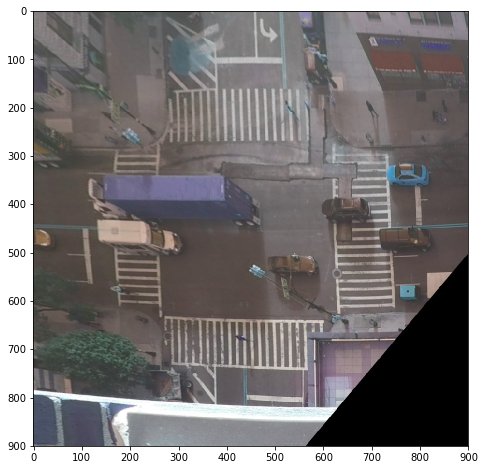

In [36]:
plt.imshow(images[0])

In [37]:
eval_pred = sess.run(predictions, feed_dict={input_ph: eval_input})
results = bbox_util.detection_out(eval_pred)

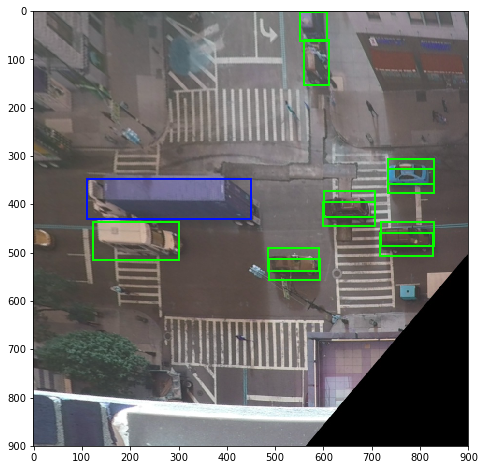

In [40]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.3]
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()

### upsample & downsample

In [7]:
tf.reset_default_graph()
input_ph = tf.placeholder(tf.float32, [None,] + list(input_shape), name="input_image")
gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 16], name="ground_truth")
with tf.variable_scope("ssd_net"):
    ssd_net = SSD()
    feats = ssd_net(input_ph)
    
with tf.variable_scope("up_net"):
    upsample_net = UpSample()
    feats_up, up_factors = upsample_net(feats)
    
with tf.variable_scope("down_net"):
    down_net = DownSample()
    feats_down = down_net(feats_up, up_factors)

In [8]:
feats_up

<tf.Tensor 'up_net/up_feats_concat:0' shape=(?, 48, 48, 3328) dtype=float32>

## Conv2DLSTM

In [21]:
seq_length = 4
batch_size = 4

#### final end-to-end model

In [45]:
#tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    seq_input_ph = tf.placeholder(tf.float32, [None, seq_length] + list(input_shape), name="input_image")
    gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 16], name="ground_truth")

    with tf.variable_scope("ssd_net"):
        ssd_net = SSD()
        ssd_input = tf.reshape(seq_input_ph, [-1,]+list(input_shape), name="reshape_seq_input")
        feats = ssd_net(ssd_input)
        #seq_feats = tf.reshape(ssd_input, [-1, seq_length]+list(input_shape), name="reshape_seq")

    with tf.variable_scope("up_net"):
        upsample_net = UpSample()
        feats_up, up_factors = upsample_net(feats)
        seq_feats_up = tf.reshape(ssd_input, [-1, seq_length]+feats_up.get_shape().as_list()[-3:], name="reshape_seq_up")

    with tf.variable_scope("core_conv_lstm"):
        cell = tf.contrib.rnn.Conv2DLSTMCell(input_shape=[48,48,3328], 
                                             output_channels=3328, kernel_shape=[5,5])
        init_state = cell.zero_state(batch_size, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feats_up, dtype=tf.float32)
        
    with tf.variable_scope("down_pooling"):
        down_net = DownSample()
        feats_down = down_net(final_state[-1], up_factors) # final_state: (c, h)
        
    with tf.variable_scope("final_prediction"):
        detector = Detector(input_shape, NUM_CLASSES)
        #predictions = detector(feats, PRIORS=False)
        final_predictions = detector(feats_down, PRIORS=False)
        
    with tf.variable_scope("loss"):
        loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(gt_ph, final_predictions)
    
    with tf.variable_scope("train"):
        global_step = tf.Variable(0, trainable=False)
        lr = tf.train.exponential_decay(3e-4, global_step, num_train//batch_size, 0.9, staircase=True, name="lr")
        train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [46]:
tf.summary.FileWriter("logs", g).close()

#### load data

#### train